
<h1> Data pipeline for UNDP Energy Moonshot Tracker </h1> 

This notebook executes the full data pipeline for ingesting the country-level energy project outputs alongside country metadata, data from the transparency portal API, donor information, and conversion factors based on our methodology to evaluate counts for direct and indirect beneficiaries. This data is then analyzed, visualized, and exported.

In [436]:
import pandas as pd
import os
import numpy as np
import warnings
import random
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import json
from tqdm import tqdm
import ast
import countrynames
import math
from urllib.request import urlopen
import re
import xlsxwriter
import csv
from functools import reduce
import openai
import os
from dotenv import load_dotenv
import hashlib
from urllib.parse import urlparse


<h2> Prepare data (Projects, Outputs, Donors, and Countries) </h2>

<h4> Country metadata and tracker </h4>

In [437]:

#country metadata
countryMetaRaw=pd.read_csv("../01_Input/03_Country Meta/countryMetadataInput.csv")

#tracker document
progressTracker=pd.read_csv("../01_Input/03_Country Meta/CO progress tracker.csv")

countryMetadata = pd.merge(countryMetaRaw, progressTracker, on='Country Code')

#print(countryMetadata)

countryMetadata.to_csv("../02_Output/03_Countries/countryMetadata.csv")

<h4> Create dataframes for projects and outputs </h4>

In [438]:
##analyze projects included

countryList=[]

projectDict={}
outputDict={}

file_path="../01_Input/00_CO Validation/"

for root, directories, files in os.walk(file_path):
    count=0
    for name in files:
        if "$" not in name and "DS" not in name and "Energy Projects" in name:
                        
            df=pd.read_excel(file_path+name)

            countryName=name.split(" -")[0]
            try:
                countryCode=countryMetadata.loc[countryMetadata['Country Name'] == countryName, 'Country Code'].values[0]
            except:
                countryCode="NA"
            countryList.append(countryCode)
            

            projectId="none"
            for index,row in df.iterrows():
                
                #if there is something in the id column, set the current project info
                if str(row["Project ID"])!="nan" and len(str(row["Project ID"]).strip())>0:
                    projectId=row["Project ID"]
                    #check if id works (need to update this to handle multi-ids)
                    if str(projectId).replace('.','').strip().isnumeric() or "missing" in str(projectId):
                        #print(projectId)
                        pass
                    
                    budget=0
                    if "Budget" in row:
                        budget=row["Budget"]
                    elif "Budget (USD)" in row:
                        budget=row["Budget (USD)"]
                    if "$" in str(budget):
                        budget=budget.split("$")[-1]
                    try:
                        budget=float(budget)
                    except:
                        #print(budget,countryName)
                        budget=-1##just a flag that the budget is tbd
                    try:
                        vf=row["VF or Non-VF"]
                    except:
                        ###this is temp
                        if len(str(projectId))<6:
                            vf="VF"
                        else:
                            vf="Non-VF"
                    title=row["Title"]
                    link=row["Link"]
                    try:
                        donors=row["Donors"]
                    except:
                        donors=""
                    
                if projectId!="none":
                    
                    count+=1

                    if str(projectId) not in projectDict:
                        projectDict[str(projectId)]={"Project ID":projectId,
                                                "Project Title":title,
                                                "Budget":budget,
                                                "Country":countryName,
                                                "Country Code":countryCode,
                                                "Link":link,
                                                "Donors":donors,
                                                "VF or Non-VF":vf,
                                                "Output Count":1}
                        newOutputId=str(projectId)+"-1"
                    else:
                        projectDict[str(projectId)]["Output Count"]+=1
                        newOutputId=str(projectId)+"-"+str(projectDict[str(projectId)]["Output Count"])

                    newOutput=row
                    newOutput["Beneficiary Category"]=str(newOutput["Beneficiary Category"]).strip()
                    projectMeta=projectDict[str(projectId)]
                    newOutput["Output ID"]=newOutputId
                    newOutput["Project ID"]=projectMeta["Project ID"]
                    newOutput["Title"]=projectMeta["Project Title"]
                    newOutput["Country Code"]=countryCode
                    newOutput["Country"]=projectMeta["Country"]
                    newOutput["Link"]=projectMeta["Link"]
                    newOutput["Budget"]=projectMeta["Budget"]
                    newOutput["VF or Non-VF"]=projectMeta["VF or Non-VF"]


                    outputDict[newOutputId]=newOutput
                else:
                    print(countryCode," - ",projectId," - ", title," - bad ID")
                            

projectDf=pd.DataFrame.from_records([*projectDict.values()])
outputDf=pd.DataFrame.from_records([*outputDict.values()])


projectDf.to_csv("../02_Output/01_Projects/projectDfValidation.csv")
outputDf.to_csv("../02_Output/02_Outputs/outputDfValidation.csv")
print(count)

944


In [439]:
#calculate project and output stats
projectList=projectDf["Project ID"].tolist()
print(len(projectList), "projects")
print(len(outputDict), "outputs")
print(projectDf["Budget"].sum(),"budget")

338 projects
944 outputs
4032427287.882919 budget


<h2> Process dataframes (Projects, Outputs, Donors, and Countries) </h2>

<h4> Clean up outputDf </h4>

In [440]:
#keep only certain headers (need to clean data to correct names)

headers=["Project ID","Output ID","Country Code","Title","Link","Budget","Beneficiary Category","Indicator","Baseline","Target","Notes","Donors","Gender (% female)","Flagship","Tag","SEH Taxonomy","RISE Taxonomy","Technology","Category","Policy-taxonomy","VF or Non-VF"]      

outputDf=outputDf[outputDf.columns[outputDf.columns.isin(headers)]]


In [441]:
#add country metadata (region and other groupings), country code, to outputDf
outputDfComplete=pd.merge(outputDf,countryMetadata,on="Country Code",how='left')
outputDfComplete.columns.values

array(['Project ID', 'Title', 'Link', 'Budget', 'Beneficiary Category',
       'Indicator', 'Baseline', 'Target', 'Notes', 'Donors',
       'Gender (% female)', 'VF or Non-VF', 'Tag', 'SEH Taxonomy',
       'RISE Taxonomy', 'Flagship', 'Technology', 'Output ID',
       'Country Code', 'Category', 'name 2', 'm49', 'continent-region',
       'sub-region', 'sids-region', 'un-member', 'undp-sids', 'un-region',
       'Country Name', 'Region', 'Economy', 'LDC', 'SIDS', 'LLDC', 'HDI',
       'Status'], dtype=object)

In [442]:
#filter outputDf based on Done statuses

completedCountries=countryMetadata[countryMetadata["Status"]=="Done"]["Country Code"].unique().tolist()

outputDfDone=outputDfComplete#[outputDfComplete["Country Code"].isin(completedCountries)]

print(len(outputDfDone),"finished outputs")


###add this to filter the data
outputDfComplete=outputDfDone

944 finished outputs


In [443]:
#donors for outputs could be updated to include atlas and pims data

<h2> Beneficiaries Conversion </h2>

<h4> direct conversion </h4>

In [444]:
#load Direct conversion Scores
directConversion=pd.read_csv("../01_Input/01_Methodology/Direct Conversion Factors.csv")
#HH data
HHdata=pd.read_csv("../01_Input/03_Country Meta/HHData.csv")
print(HHdata)

     Country or area Average household size (number of members)  \
0           Zimbabwe                                       4.02   
1           Zimbabwe                                       4.08   
2           Zimbabwe                                       4.16   
3           Zimbabwe                                       4.04   
4           Zimbabwe                                       4.15   
...              ...                                        ...   
1054         Albania                                          4   
1055         Albania                                       4.35   
1056     Afghanistan                                       8.04   
1057     Afghanistan                                       7.75   
1058             NaN                                        NaN   

     Data source category Reference date (dd/mm/yyyy)  
0                    MICS                      1/7/19  
1                     DHS                  27/09/2015  
2                    MICS  

In [445]:
#add column for direct beneficiaries convert
  
def getDirectFactor(category):
    try:
        return directConversion.loc[directConversion["Beneficiary Category"]==category,"Factor"].values[0]
    except:
        return 0
    
def convertHH(row):
    target=str(row["Target"]).replace(',', '')
    if "HH" in target:
        try:
            householdSize=HHdata[HHdata["Country or area"]==row["Country Name"]].iloc[0]["Average household size (number of members)"]
        except:
            householdSize=5
            print("no HH for", row["Country Name"])
        try:
            return int(target.split("HH")[0])*float(householdSize)
        except:
            print(target,"contains HH but broken")
            return target
    else:
        try: 
            return int(target)
        except:
            print(target,row["Country Name"],"incorrect format")
            return target
    
outputDfComplete["Direct Conversion Factor"]=outputDfComplete["Beneficiary Category"].apply(lambda x: getDirectFactor(x))
   
outputDfComplete['Target'] =  outputDfComplete.apply(convertHH, axis=1)

outputDfComplete["Direct Beneficiaries"]=(pd.to_numeric(outputDfComplete['Target'], errors='coerce').fillna(0)-pd.to_numeric(outputDfComplete['Baseline'], errors='coerce').fillna(0))*outputDfComplete["Direct Conversion Factor"]                                                                    
outputDfComplete["Direct Beneficiaries"] = pd.to_numeric(outputDfComplete["Direct Beneficiaries"], errors='coerce')



4936.0 Zambia incorrect format
13780.0 Zambia incorrect format
nan Zambia incorrect format
810000.0 Zambia incorrect format
1002.0 Zambia incorrect format
0.15 Zambia incorrect format
2.025 Malawi incorrect format
nan Malawi incorrect format
nan South Africa incorrect format
1.8 South Africa incorrect format
0.73 Samoa incorrect format
20000.0 Jamaica incorrect format
0.01 Jamaica incorrect format
76.2 Jamaica incorrect format
15000000.0 Jamaica incorrect format
40.0 Jamaica incorrect format
5000.0 Jamaica incorrect format
1 new energy mix  Algeria incorrect format
0.3 Yemen incorrect format
0.2 Yemen incorrect format

0.481 Yemen incorrect format
nan Belize incorrect format
nan Belize incorrect format
nan Belize incorrect format
nan Belize incorrect format
nan Belize incorrect format
nan Iran incorrect format
0.375 Iran incorrect format
1.5 Iran incorrect format
20000.0 Iran incorrect format
146167.0 Iran incorrect format
3042.0 Comoros incorrect format
nan Comoros incorrect format
0.

In [446]:
outputDfComplete

,Project ID,Title,Link,Budget,Beneficiary Category,Indicator,Baseline,Target,Notes,Donors,...,Country Name,Region,Economy,LDC,SIDS,LLDC,HDI,Status,Direct Conversion Factor,Direct Beneficiaries
0,117913.0,Résilience des communautés et des écosystèmes,http://open.undp.org/projects/00117913,3459600.0,Electricity Access,Nombre de ménages ayant accès à l’énergie sola...,0,3697.5,"Nombre de ménages dirigés par les hommes: 650,...",UNDP,...,Togo,RBA,Low income,LDC,NaN,NaN,Low,CO Update,1,3697.5
1,117913.0,Résilience des communautés et des écosystèmes,http://open.undp.org/projects/00117913,3459600.0,nan,Pourcentage des producteurs de charbon dans le...,0,460,Il ya 576 productrices de chanbons qui ont été...,UNDP,...,Togo,RBA,Low income,LDC,NaN,NaN,Low,CO Update,0,0.0
2,117913.0,Résilience des communautés et des écosystèmes,http://open.undp.org/projects/00117913,3459600.0,nan,Pourcentatge des femmes productrices de charbo...,0,460,Il ya 576 productrices de chanbons qui ont été...,UNDP,...,Togo,RBA,Low income,LDC,NaN,NaN,Low,CO Update,0,0.0
3,134793.0,Accès aux énergies renouvelables en milieu rur...,http://open.undp.org/projects/00134793,1431552.0,Electricity Access,"Nombre de ménages dans les villages ciblés, y ...",0,6525.0,Nombre de ménages dirigés par les hommes: 1200...,UNDP,...,Togo,RBA,Low income,LDC,NaN,NaN,Low,CO Update,1,6525.0
4,134793.0,Accès aux énergies renouvelables en milieu rur...,http://open.undp.org/projects/00134793,1431552.0,nan,Environ 50 000 personnes au Total,10,50000,Environ 50 000 personnes au Total,UNDP,...,Togo,RBA,Low income,LDC,NaN,NaN,Low,CO Update,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,4998,Grid-connected Small-Scale Photovoltaic Syste,PIMS+,3536364.0,Energy (MW added),Electricity generation capacity shfited from f...,0,18.0,The project opeded markets for use of roof top...,GEF,...,Egypt,RBAS,Lower middle income,NaN,NaN,NaN,High,Updated-2,17500,315000.0
940,130275,Promote small-scale PV-UNDP-EGY,Quantum,1103288.0,Energy (MW added),Electricity generation capacity shfited from f...,0,1.3,The added PV capacities will be mainly impleme...,Japan,...,Egypt,RBAS,Lower middle income,NaN,NaN,NaN,High,Updated-2,17500,22750.0
941,130610,Multilateral Support to COP27,Qunatum,1500000.0,Energy (MW added),Electricity generation capacity shfited from f...,0,1.5,The added PV capacities will be mainly impleme...,EU,...,Egypt,RBAS,Lower middle income,NaN,NaN,NaN,High,Updated-2,17500,26250.0
942,132688,Projet d’Electrification Rurale en Zones Isol...,NaN,329490000.0,Electricity Access,"1. Percentage of populations, disaggregated by...",0,600000,The objective of PERZI is to create the condit...,"Gouvernment, UNDP,",...,Mauritania,RBA,Lower middle income,LDC,NaN,NaN,Medium,Updated-2,1,600000.0


<h4> indirect conversion </h4>

In [447]:
#open electricity access % data
eAccessDf=pd.read_csv("../01_Input/02_Energy Data/API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_5358776/API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_5358776.csv")
popDf=pd.read_csv("../01_Input/02_Energy Data/API_SP.POP.TOTL_DS2_en_csv_v2_5436324/API_SP.POP.TOTL_DS2_en_csv_v2_5436324.csv")
renewableDf=pd.read_csv("../01_Input/02_Energy Data/API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_5359592/API_EG.FEC.RNEW.ZS_DS2_en_csv_v2_5359592.csv")
cleanDf=pd.read_csv("../01_Input/02_Energy Data/API_EG.CFT.ACCS.ZS_DS2_en_csv_v2_5362815/API_EG.CFT.ACCS.ZS_DS2_en_csv_v2_5362815.csv")

renewableDf=renewableDf.set_index("Country Code")
cleanDf=cleanDf.set_index("Country Code")
eAccessDf=eAccessDf.set_index("Country Code")
popDf=popDf.set_index("Country Code")

In [448]:
dfList=[]
proportionDict={}
for country in eAccessDf.index:
    
    elAccessPercent=(100-eAccessDf.loc[country]["2020"])/100
    cleanPercent=cleanDf.loc[country]["2020"]/100
    effiPercent=eAccessDf.loc[country]["2020"]/100
    renewPercent=renewableDf.loc[country]["2019"]/100
    
    countryPop=popDf.loc[country]["2020"]
    
    elAccess=elAccessPercent*countryPop
    clean=cleanPercent*countryPop
    effi=effiPercent*countryPop
    renew=renewPercent*countryPop
    
    count=0
    total=0
    
    for val in [elAccess,clean,effi,renew]:
        if not pd.isna(val):
            count+=1
            total+=val
    
    if count>0:
        overall=total/count
    else:
        overall=0
        
    proportionDict[country]={"Electricity access":elAccessPercent,"Clean cooking":cleanPercent,"Energy efficiency":effiPercent,"Renewable energy":renewPercent,"Overall":overall/countryPop}
    dfList.append({"Country Code":country,"Electricity access":elAccess,"Clean cooking":clean,"Energy efficiency":effi,"Renewable energy":renew,"Overall":overall})

indirectPotentials=pd.DataFrame.from_records(dfList)

indirectPotentials.to_csv("../02_Output/03_Countries/indirectPotential.csv")

In [449]:
# #load Indirect conversion scores
# indirectConversion=pd.read_csv("../01_Input/01_Methodology/Indirect Conversion Factors.csv")
# #load RISE scores
# riseScores=pd.read_excel("../01_Input/02_Energy Data/RISE Scores-2.xlsx")

# def getIndirectBeneficiaries(row):
#     if row["Beneficiary Category"]=="Policy or Regulatory Framework":
#         try:
#             category=row["RISE Taxonomy"]
#         except:###DELETE
#             category="Overall"
        
#         proportion=proportionDict[row["Country Code"]][category]
#         if "Scope" not in row.keys().tolist():#####DELETE
#             row["Scope"]="National"
        
#         if row["Scope"]=="National":
#             potentialPopulation=popDf.loc[row["Country Code"]]["2020"]
#         else:
#             potentialPopulation=row["Policy Population"]
        
#         return potentialPopulation*proportion
        
#     else:
#         return 0
    
# outputDfComplete["Indirect Beneficiaries"]=outputDfComplete.apply(lambda row: getIndirectBeneficiaries(row),axis=1)

# outputDfComplete["Indirect Beneficiaries"] = pd.to_numeric(outputDfComplete["Indirect Beneficiaries"], errors='coerce')

# print(outputDfComplete[outputDfComplete["Beneficiary Category"]=="Policy or Regulatory Framework"])


In [450]:
##add direct and indirect beneficiaries count to projectDf

projectDf["Direct Beneficiaries"]=projectDf["Project ID"].apply(lambda x: outputDfComplete[outputDfComplete["Project ID"]==x]["Direct Beneficiaries"].sum())

ghgDfComplete=outputDfComplete[outputDfComplete["Beneficiary Category"]=="GHG Emissions Reduction"]

def sumGhg(ghgList):
    ghg=0
    for i in ghgList:
        ghg+=float(i)
    return ghg
    

projectDf["GHG Emissions Reduction"]=projectDf["Project ID"].apply(lambda x: sumGhg(ghgDfComplete[ghgDfComplete["Project ID"]==x]["Target"].tolist()))



# projectDf["Indirect Beneficiaries"]=projectDf["Project ID"].apply(lambda x: outputDfComplete[outputDfComplete["Project ID"]==x]["Indirect Beneficiaries"].sum())


<h4> Add energy efficiency (and GHG emissions reduction?) </h4>

In [451]:
# outputDfComplete["GHG Emissions Reduction"]=outputDfComplete.apply(lambda row: (row["Beneficiary Category"]=="GHG Emissions Reduction")*row["Target"],axis=1)
# # #Energy Saved (MJ)

#####to projects instead now??

In [452]:
productiveUseCategories=[
    "Agriculture and Food System",
    "Health Services",
    "Education Services",
    "Transportation and E-mobility Services",
    "Water Services",
    "Energy Infrastructure Services",
    "Clean Cooking"
]

In [453]:

#community centers
#displacement settings

def getBeniCategory(row):
    if row["Beneficiary Category"] in productiveUseCategories:
        outputCategory="Energy Access"
    elif row["Beneficiary Category"] in ["Electricity Access","Energy (MW added)","Clean Cooking"]:
        if row["SEH Taxonomy"] == "Accelerating just energy transition":
            outputCategory="Energy Transition"
        elif row["SEH Taxonomy"]=="Close the gap on energy access":
            outputCategory="Energy Access"
        else:
            outputCategory="Needs SEH Taxonomy"
            print(row["Country Code"])##these need seh taxonomy added!
    elif row["Beneficiary Category"]=="Policy or Regulatory Framework":
        outputCategory="Policy"
    elif row["Beneficiary Category"]=="Energy Efficiency Services":
        outputCategory="Energy Transition"
    elif row["Beneficiary Category"]=="GHG Emissions Reduction":
        outputCategory="GHG Emissions Reduction"
    else:
        outputCategory="Other"
    return outputCategory
        
outputDfComplete["Output Category"]=outputDfComplete.apply(lambda row: getBeniCategory(row),axis=1)


UKR
UKR
UKR
UKR
UKR
UKR
UKR
XXK
XXK
SDN
MMR
MMR
MMR
MMR
MMR
MMR


In [454]:
def getBeniSubcategory(row):
    
    if row["Output Category"]=="Energy Transition":
        if row["Beneficiary Category"]=="Energy Efficiency Services":
            beneficiaryCategory="Efficiency"
        elif type(row["Technology"])==str: 
            beneficiaryCategory=row["Technology"]
        else:
            beneficiaryCategory="Transition Missing"    
    elif row["Beneficiary Category"] in productiveUseCategories:
        beneficiaryCategory=row["Beneficiary Category"]##this changes nothing
        
    elif row["Beneficiary Category"] in ["Electricity Access","Energy (MW added)"]:
        beneficiaryCategory="Clean Electricity"

    elif row["Beneficiary Category"]=="Policy or Regulatory Framework":
        beneficiaryCategory=row["RISE Taxonomy"]
        
    else:##need to add finance here
        beneficiaryCategory="Other"
    return beneficiaryCategory     

        
outputDfComplete["Beneficiary Category Pre"]=outputDfComplete["Beneficiary Category"]
outputDfComplete["Beneficiary Category"]=outputDfComplete.apply(lambda row: getBeniSubcategory(row),axis=1)

<h1> Update outputs, projects, donors, and country data with api, pims, and summary stats </h1>

<h3>download portfolio data from API</h3>

In [455]:
#should refactor this so there is a single retreival of country metadata
allCountryCodes=pd.read_csv("../01_Input/03_Country Meta/country-iso.csv")["alpha-3"].unique().tolist()
unregions=pd.read_csv("../02_Output/03_Countries/countryMetadata.csv").set_index("Country Code")
bureaus=pd.read_csv("../01_Input/03_Country Meta/country-iso.csv").set_index("alpha-3")

In [456]:
def nameToIsoGlobal(countryName):
    iso=countrynames.to_code_3(countryName, fuzzy=True)
    if iso==None:
        iso="NA"
    return iso

In [457]:
solutionsDict={"Others":7,
"Enhance national prevention and recovery capacities for resilient societies":3,
"Promote nature-based solutions for a sustainable planet":4,
"Keeping people out of poverty":1,
"Close the energy gap":5,
"Strengthen gender equality and the empowerment of women and girls":6,
"Strenghten gender equality and the empowerment of women and girls":6,
              "Strengthen effective, inclusive and accountable governance":2}

In [458]:
#test
# j = pd.read_json('https://api.open.undp.org/api/project_list/?year={}&operating_unit={}'.format("2022","TUV"))
# for d in j.data.data:
#     print(d)

In [459]:

def downloadFullPortfolio():

    #fundingCategories=pd.read_csv("../../SIDS-Data-Platform-API/api/data/portfolio/fundingCategories.csv",encoding="utf-8")
    #fundingCategories=fundingCategories.set_index('donor')

    df = pd.DataFrame()

    rows=[]


    for country in allCountryCodes:
        print(country)
        for yr in range(2010,2023):
            j = pd.read_json('https://api.open.undp.org/api/project_list/?year={}&operating_unit={}'.format(yr,country))
            for d in j.data.data:
                #print(d)
                try:
                    sdg = [int(s['id']) for s in d['sdg']]
                except:
                    sdg = None
                try:
                    solution = [s['name'] for s in d['signature_solution']]
                except:
                    solution = None

                title=d['title']

                donors= d['donor']
                
                unregion=unregions.loc["AFG"]["un-region"]
                bureau=bureaus.loc["AFG"]["undp-region"]

                line = {'Project ID':d['project_id'],
                        'country_atlas':country,
                        'un-region':unregion,
                        'bureau':bureau,
                        'year':yr,
                        'title_atlas':d['title'],
                        'description':d['description'],
                        'sector':d['sector'],
                        'budget_atlas':d['budget'],
                        'expense':d['expense'],
                        'sdgs':sdg,
                        'solution':solution,
                        'donors_atlas':donors
                       }

                #l = pd.DataFrame(line)

                rows.append(line)

    df=pd.DataFrame.from_records(rows)        

    return df


In [460]:
# fullAtlasPortfolio=downloadFullPortfolio()
# fullAtlasPortfolio.to_csv('../02_Output/01_Projects/allAtlasData.csv',ignore_index=True, encoding="utf-8")

In [461]:
#filter projects based on if energy is included in title, description, sector, sdg7, solution 5

newProjects=[]

keywords=["Energy","Electric","Électrique", "Eléctric","Fuel","Clean Cooking", "Energia","Energie","Grid","Renewable"]

df=pd.read_csv('../02_Output/01_Projects/allAtlasData.csv')


df.rename(columns={'donors': 'donors_atlas', 'id': 'Project ID'}, inplace=True)

print(df)
for index,row in df.iterrows():

    if '7' in row['sdgs'].strip('][').split(', ') or 'Close the energy gap' in row['solution'] or any(sub.lower() in row['title'].lower() for sub in keywords) or any(sub.lower() in row['description'].lower() for sub in keywords):
        source="Non-VF"
        for donor in ast.literal_eval(row['donors_atlas']):#.strip('][').split(', '):
            try:
                if fundingJson[donor]['category']=="Vertical Funds":
                    source="VF"
            except:
                pass#print(donor)
        row["funding source"]=source
    
        lifetimeBudget=df[df["Project ID"]==row["Project ID"]]["budget"].sum()
        row["lifetime budget"]=lifetimeBudget
        
        
        newProjects.append(row)
        
        
dfFiltered=pd.DataFrame.from_records(newProjects)

dfFiltered.to_csv('../02_Output/01_Projects/atlasEnergyPortfolio.csv')




##2022 total of 570M

       Project ID country           un-region bureau  year  \
0           61104     AFG  Asia-Pacific Group   RBAP  2012   
1           57359     AFG  Asia-Pacific Group   RBAP  2012   
2           60777     AFG  Asia-Pacific Group   RBAP  2012   
3           58922     AFG  Asia-Pacific Group   RBAP  2012   
4           47111     AFG  Asia-Pacific Group   RBAP  2012   
...           ...     ...                 ...    ...   ...   
50056      119624     ZWE  Asia-Pacific Group   RBAP  2022   
50057      118587     ZWE  Asia-Pacific Group   RBAP  2022   
50058      108414     ZWE  Asia-Pacific Group   RBAP  2022   
50059       96722     ZWE  Asia-Pacific Group   RBAP  2022   
50060       96886     ZWE  Asia-Pacific Group   RBAP  2022   

                                                   title  \
0      Law and Order Trust Fund for Afghanistan – Pha...   
1      National Area-Based Development Programme Phas...   
2            Afghanistan Peace & Reintegration Programme   
3       Afghani

<h4> add atlas and pims metadata to project df </h4>

In [462]:
#ATLAS api to get project metadata


##note during refactor, replace this import with the file directly updated including api results
atlasData=pd.read_csv("../02_Output/01_Projects/atlasEnergyPortfolio.csv",usecols=["Project ID","sdgs","solution","description","donors_atlas"])

print(atlasData)
#this should pull disaggregated donor funding from api

projectDf=pd.merge(projectDf,atlasData,on="Project ID",how="left").drop_duplicates(subset='Project ID')

projectDf["Donors"]= projectDf['donors_atlas'].combine_first(projectDf['Donors'])

projectDf=projectDf.drop(columns=["donors_atlas"])

projectDf.to_csv("../02_Output/01_Projects/projectDfFull.csv")

projectDf



      Project ID                                        description  \
0          88841  Economic growth is accelerated to reduce vulne...   
1          88841  Economic growth is accelerated to reduce vulne...   
2          93793  National Human Development Report Extractive I...   
3          88841  Economic growth is accelerated to reduce vulne...   
4          94515  Support Afghanistan Livelihoods and Mobility (...   
...          ...                                                ...   
3620      133885  Towards Ending AIDS as a Public Health Threat ...   
3621      143014  Supporting the implementation of Low Emissions...   
3622      118606  Conversion from HFC-134a to isobutane in the m...   
3623      137178  Reduction of HCFC-22 through the adoption of e...   
3624       95621  Climate change mitigation and adaptation scale...   

               sdgs                                     solution  \
0            [1, 7]  ['Others', 'Keeping people out of poverty']   
1          

,Project ID,Project Title,Budget,Country,Country Code,Link,Donors,VF or Non-VF,Output Count,Direct Beneficiaries,GHG Emissions Reduction,description,sdgs,solution
0,117913.0,Résilience des communautés et des écosystèmes,3459600.0,Togo,TGO,http://open.undp.org/projects/00117913,['UNITED NATIONS DEVELOPMENT PRO'],Non-VF,3,3697.5,0.0,Il s’agit de la promotion du développement Loc...,[13],"['Others', 'Close the energy gap']"
4,134793.0,Accès aux énergies renouvelables en milieu rur...,1431552.0,Togo,TGO,http://open.undp.org/projects/00134793,['UNITED NATIONS DEVELOPMENT PRO'],Non-VF,3,31525.0,0.0,Accélération de l’accès aux énergies renouvela...,[7],['Close the energy gap']
6,91204.0,Apoyo a la Modernización de La Gestión Ambiental,4202031.0,Panama,PAN,https://open.undp.org/projects/00082182,UNDP (TRAC 4000) CLIMATE PROMISE (28708) - NDC...,Non-VF,1,0.0,0.0,NaN,NaN,NaN
7,133871.0,Beyond Recovery COVID19 Energy,473000.0,Panama,PAN,https://www.undp.org/es/panama/noticias/dos-ag...,['UNITED NATIONS DEVELOPMENT PRO'],Non-VF,2,17500.0,0.0,"Acceso universal, a través de la implementació...","[1, 5, 9]",['Promote nature-based solutions for a sustain...
9,6613,Africa Mini-grids Program,1363947.0,Zambia,ZMB,PIMS+,NaN,VF,3,4936.0,13780.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,4998,Grid-connected Small-Scale Photovoltaic Syste,3536364.0,Egypt,EGY,PIMS+,GEF,VF,1,315000.0,0.0,NaN,NaN,NaN
535,130275,Promote small-scale PV-UNDP-EGY,1103288.0,Egypt,EGY,Quantum,Japan,Non-VF,1,22750.0,0.0,NaN,NaN,NaN
536,130610,Multilateral Support to COP27,1500000.0,Egypt,EGY,Qunatum,EU,Non-VF,1,26250.0,0.0,NaN,NaN,NaN
537,132688,Projet d’Electrification Rurale en Zones Isol...,329490000.0,Mauritania,MRT,NaN,"Gouvernment, UNDP,",Non-VF,1,600000.0,0.0,NaN,NaN,NaN


In [463]:
#PIMS export to get project metadata
pimsData=pd.read_excel("../01_Input/05_PIMS/pims-2-16.xlsx")

pimsDes={}

for index,project in pimsData.iterrows():
    if project["Project ID"] in projectDf["Project ID"].tolist():
        if not pd.isna(project["Project Description"]):
            pimsDes[project["Project ID"]]=project["Project Description"]

def addPimsDes(projectId,description):
    if pd.isna(description):
        if projectId in pimsDes:
            return pimsDes[projectId]
    
    return description
    


In [464]:
projectDf["description"]=projectDf.apply(lambda row: addPimsDes(row["Project ID"],row["description"]),axis=1)

print(projectDf["description"])

0      Il s’agit de la promotion du développement Loc...
4      Accélération de l’accès aux énergies renouvela...
6                                                    NaN
7      Acceso universal, a través de la implementació...
9                                                    NaN
                             ...                        
534                                                  NaN
535                                                  NaN
536                                                  NaN
537                                                  NaN
538                                                  NaN
Name: description, Length: 338, dtype: object


<h3> gender markers </h3>

In [465]:
gender_df=pd.read_excel("../01_Input/06_Gender/GM SS4 SS5 14Jan2024.xlsx")
gender_dict=dict(zip(gender_df['Project Number'], gender_df['Marker Text']))
print(gender_dict)

{96168: 'GEN2', 101293: 'GEN1', 102775: 'GEN2', 104400: 'GEN2', 110941: 'GEN2', 1000573: 'GEN2', 96606: 'GEN2', 108253: 'GEN2', 120509: 'GEN2', 134230: 'GEN2', 112311: 'GEN2', 112042: 'GEN2', 101356: 'GEN2', 103304: 'GEN2', 107047: 'GEN2', 1000553: 'GEN3', 108562: 'GEN2', 97828: 'GEN2', 1000372: 'GEN1', 112296: 'GEN1', 129287: 'GEN2', 1000444: 'GEN0', 54966: 'GEN2', 101711: 'GEN2', 123413: 'GEN2', 131509: 'GEN2', 130986: 'GEN1', 119240: 'GEN1', 130577: 'GEN1', 131175: 'GEN2', 96384: 'GEN2', 96410: 'GEN3', 107983: 'GEN3', 128847: 'GEN2', 131157: 'GEN1', 96170: 'GEN2', 113742: 'GEN2', 113743: 'GEN2', 115515: 'GEN2', 122351: 'GEN2', 132452: 'GEN2', 90309: 'GEN2', 98124: 'GEN2', 98222: 'GEN2', 98610: 'GEN2', 131546: 'GEN2', 106888: 'GEN3', 112399: 'GEN2', 118332: 'GEN2', 126347: 'GEN2', 130650: 'GEN2', 1000318: 'GEN2', 99740: 'GEN1', 131307: 'GEN2', 92275: 'GEN2', 94434: 'GEN3', 103905: 'GEN0', 104433: 'GEN2', 113647: 'GEN2', 114327: 'GEN2', 121017: 'GEN2', 123359: 'GEN2', 130941: 'GEN2', 

In [466]:

def get_gender_marker(projectId):
    try:
        projectId=int(projectId)
        if projectId in gender_dict:
            print("success")
            return(gender_dict[projectId])
        else:
            return "Missing"
    except:
        return "Missing project id"


In [467]:
projectDf["Gender Marker"]=projectDf["Project ID"].apply(lambda x: get_gender_marker(x))

success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success
success


In [468]:
print(projectDf)

    Project ID                                      Project Title  \
0     117913.0      Résilience des communautés et des écosystèmes   
4     134793.0  Accès aux énergies renouvelables en milieu rur...   
6      91204.0   Apoyo a la Modernización de La Gestión Ambiental   
7     133871.0                     Beyond Recovery COVID19 Energy   
9         6613                          Africa Mini-grids Program   
..         ...                                                ...   
534       4998      Grid-connected Small-Scale Photovoltaic Syste   
535     130275                    Promote small-scale PV-UNDP-EGY   
536     130610                      Multilateral Support to COP27   
537     132688  Projet d’Electrification  Rurale en Zones Isol...   
538     131201                                         Paix Verte   

          Budget     Country Country Code  \
0      3459600.0        Togo          TGO   
4      1431552.0        Togo          TGO   
6      4202031.0      Panama        

<h3>Update countryMetadata and donorDf</h3>

<h4> Extract donor df </h4>

In [469]:
#analyze data from project list
print(projectDf["Donors"].unique().tolist())


#donorList

#get total projects

#add metadata from manual categories


["['UNITED NATIONS DEVELOPMENT PRO']", 'UNDP (TRAC 4000) CLIMATE PROMISE (28708) - NDC Partnership (PAF)\nAes Panamá S.R.L\nFederal Ministry For The Environment, Nature Conservation And Nuclear Safety\nPan-Government', nan, 'UNDP, UNICEF, UNFPA, UNCDF, RCO, UNDSS, UNCTAD, DCO.', 'GEF', 'Department of Energy. South Africa', 'UNDP LVGA', 'Japan', "['Aver, Inc. S.A.L', 'Beesline International SAL', 'Biomass S. A. L.', 'ELCIR S.A.L', 'EUROPEAN COMMISSION', 'KREDITANSTALT FUR WIEDERAUFBAU', 'MINISTRY OF FOREIGN AFFAIRS, NORWAY', 'Petco s.a.l', 'Roky Plast SAL', 'UNITED NATIONS DEVELOPMENT PRO']", '', 'UNDP', 'Government of Italy ', "['Generic foundation donor code', 'MPTF-Supporting Resilient Livelihoods and Food Security in Yemen JP (ERRY II )', 'UNITED NATIONS DEVELOPMENT PRO']", "['Generic foundation donor code', 'MPTFO-JP Yemen ERRY III', 'UNITED NATIONS DEVELOPMENT PRO']", "['Kuwait Fund for Arab Economic Development']", "['EUROPEAN COMMISSION']", 'FCDO, GAC', 'GF', "['Global Environme

<h4> update country metadata </h4>

In [470]:
updatedCountryList=[]

#add country stats on project and output count and budget to metadata
for index,row in countryMetadata.iterrows():
    country=row['Country Code']
        
    filteredOutputs=outputDfComplete[outputDfComplete["Country Code"]==country]
    
    row["Project Count"]=len(filteredOutputs["Project ID"].unique().tolist())
    row["Output Count"]=len(filteredOutputs)
    row["Budget Total"]=filteredOutputs["Budget"].sum()

    updatedCountryList.append(row)    

updatedCountryMeta=pd.DataFrame.from_records(updatedCountryList)


##add direct and indirect beneficiaries count to countryMeta

updatedCountryMeta["Direct Beneficiaries"]=updatedCountryMeta["Country Code"].apply(lambda x: outputDfComplete[outputDfComplete["Country Code"]==x]["Direct Beneficiaries"].sum())
# updatedCountryMeta["Indirect Beneficiaries"]=updatedCountryMeta["Country Code"].apply(lambda x: outputDfComplete[outputDfComplete["Country Code"]==x]["Indirect Beneficiaries"].sum())

updatedCountryMeta.to_csv("../02_Output/03_Countries/countryMetadata.csv")

<h2> Analyze, Plot, and Export </h2>

<h4> analyze beneficiary outputs </h4>

In [471]:
beneTiers={}
for index,row in directConversion.iterrows():
    if row["Tier"] not in beneTiers:
        beneTiers[row["Tier"]]=[]
    beneTiers[row["Tier"]].append(row["Beneficiary Category"])

In [472]:
summaryDfList=[]

def getBeneSums(row,df):

    row["Direct Beneficiaries"]=df["Direct Beneficiaries"].sum()
    row["Energy Access"]=df[df["Beneficiary Category"].isin(["Electricity Access","Energy (MW added)"])]["Direct Beneficiaries"].sum()
    row["Productive Use"]=df[df["Beneficiary Category"].isin(["Health Services","Water Services","Agricultural Services","Education Services"])]["Direct Beneficiaries"].sum()
    
    dfNoDuplicates=df.drop_duplicates(subset='Project ID') ##
    row["Budget Sum (M USD)"]=dfNoDuplicates["Budget"].sum()
    
    #row["Indirect Beneficiaries"]=df["Indirect Beneficiaries"].sum()
    
    #row["Energy Saved (MJ)"]=df["Energy Saved (MJ)"].sum()

    return row


def getProjectCounts(row,df):
    projectIds=df["Project ID"].unique().tolist()
    row["Project Count"]=len(projectIds)    
    return row

def getCountryCounts(row,df):
    countryCodes=df["Country Code"].unique().tolist()
    row["Country Count"]=len(countryCodes)    
    return row
    
    
def getSummaryInfo(row,df):
    row=getBeneSums(row,df)
    row=getProjectCounts(row,df)
    row=getCountryCounts(row,df)
    return row
    
    
for projectType in ["Total","VF","Non-VF"]:
    
    if projectType=="Total":
        outputDfFiltered=outputDfComplete
    else:
        outputDfFiltered=outputDfComplete[outputDfComplete["VF or Non-VF"]==projectType]
    
    ##first add values for unfiltered 
    summaryDfList.append(getSummaryInfo({"Category":"All","Subcategory":"All","VF or Non-VF":projectType},outputDfFiltered))

    for grouping in ["SIDS","LDC","LLDC"]:
        summaryDfList.append(getSummaryInfo({"Category":"Grouping","Subcategory":grouping,"VF or Non-VF":projectType},outputDfFiltered[outputDfFiltered[grouping]==grouping]))

    for economy in outputDfFiltered["Economy"].dropna().unique().tolist():
        summaryDfList.append(getSummaryInfo({"Category":"Economy","Subcategory":economy,"VF or Non-VF":projectType},outputDfFiltered[outputDfFiltered["Economy"]==economy]))

    for hdi in outputDfFiltered["HDI"].dropna().unique().tolist():
        summaryDfList.append(getSummaryInfo({"Category":"HDI","Subcategory":hdi,"VF or Non-VF":projectType},outputDfFiltered[outputDfFiltered["HDI"]==hdi]))

    for region in outputDfFiltered["Region"].dropna().unique().tolist():
        summaryDfList.append(getSummaryInfo({"Category":"Region","Subcategory":region,"VF or Non-VF":projectType},outputDfFiltered[outputDfFiltered["Region"]==region]))

    #for donorCategory in ["Government","UN Agencies","Other","UN Pooled Funds","European Union","DFI","Private Sector"]:

    for beneTier in beneTiers:
        summaryDfList.append(getSummaryInfo({"Category":"Beneficiary Tier","Subcategory":beneTier,"VF or Non-VF":projectType},outputDfFiltered[outputDfFiltered["Beneficiary Category"].isin(beneTiers[beneTier])]))

    for beneCategory in outputDfFiltered["Beneficiary Category"].dropna().unique().tolist():
        df=outputDfFiltered[outputDfFiltered["Beneficiary Category"]==beneCategory]
#         if beneCategory=="Policy or Regulatory Framework":
#             for taxonomy in outputDfFiltered["Policy-taxonomy"].dropna().unique().tolist():     
#                 summaryDfList.append(getSummaryInfo({"Category":"Beneficiary Category","Subcategory":"Policy - "+taxonomy,"VF or Non-VF":projectType},df[df["Policy-taxonomy"]==taxonomy]))
#         else:
        summaryDfList.append(getSummaryInfo({"Category":"Beneficiary Category","Subcategory":beneCategory,"VF or Non-VF":projectType},df))

summaryDf=pd.DataFrame.from_records(summaryDfList)
summaryDf.to_csv("../02_Output/05_Summary/summaryDf.csv")
summaryDf


,Category,Subcategory,VF or Non-VF,Direct Beneficiaries,Energy Access,Productive Use,Budget Sum (M USD),Project Count,Country Count
0,All,All,Total,1.051295e+08,0.0,33945862.51,4.032427e+09,338,118
1,Grouping,SIDS,Total,5.617323e+06,0.0,1083927.66,2.325317e+08,50,19
2,Grouping,LDC,Total,5.512550e+07,0.0,32463405.91,1.439460e+09,113,40
3,Grouping,LLDC,Total,3.234642e+07,0.0,17731696.00,4.970197e+08,85,29
4,Economy,Low income,Total,5.376131e+07,0.0,30210899.00,2.290660e+09,60,24
...,...,...,...,...,...,...,...,...,...
129,Beneficiary Category,Energy Infrastructure Services,Non-VF,4.542340e+05,0.0,0.00,5.075817e+07,15,8
130,Beneficiary Category,Some Sources,Non-VF,8.585325e+05,0.0,0.00,4.709940e+07,3,3
131,Beneficiary Category,Transition Missing,Non-VF,3.499400e+05,0.0,0.00,9.343724e+07,7,6
132,Beneficiary Category,Unknown,Non-VF,8.135500e+04,0.0,0.00,3.820547e+07,7,3


In [473]:


def create_sideways_bar_chart(df, category_name, value, custom_chart_info):
    # Set default metadata values
    chart_info = {
        'width': 8,
        'height': .8,
        'style': 'whitegrid',
        'palette': 'pastel',
        'xlabel': 'Values',
        'ylabel': 'Subcategories',
        'title': f'{category_name} - Sideways Bar Chart',
        'xlabel_fontsize': 12,
        'ylabel_fontsize': 12,
        'title_fontsize': 14
    }

    # Update metadata with provided values (if any)
    if custom_chart_info:
        chart_info.update(custom_chart_info)

    # Filter DataFrame for the specified category
    category_data = df[df["Category"] == category_name]

    # Create a horizontal bar chart using Seaborn
    plt.figure(figsize=(chart_info['width'], chart_info['height']*len(category_data)))  # Set the figure size
    
    # Customize Seaborn style and color palette
    sns.set(style=chart_info['style'])
    colors = sns.color_palette(chart_info['palette'])
    
    if isinstance(value,list):
        pass
        #####
        
    elif isinstance(value,str):
        # Create the sideways bar chart using Seaborn's barplot
        sns.barplot(x=value, y="Subcategory", data=category_data, palette=colors)

    # Customize labels and title
    plt.xlabel(chart_info['xlabel'], fontsize=chart_info['xlabel_fontsize'])
    plt.ylabel(chart_info['ylabel'], fontsize=chart_info['ylabel_fontsize'])
    plt.title(chart_info['title'], fontsize=chart_info['title_fontsize'])
    
    # Display the chart
    plt.show()

# # Sample DataFrame
# data = {
#     'Category': ['A', 'A', 'A', 'B', 'C', 'C'],
#     'Subcategory': ['Sub1', 'Sub2', 'Sub3', 'Sub2', 'Sub1', 'Sub2'],
#     'Direct Beneficiaries': [40, 60, 35, 90, 50, 70],
#     'Budget Sum (M USD)': [10, 15, 20, 25, 30, 35]
#     #'Indirect Beneficiaries': [20, 30, 25, 40, 15, 25]
# }

# df = pd.DataFrame(data)

# chart_info = {
#     'palette': 'deep',
#     'xlabel': 'Custom Values',
#     'ylabel': 'Custom Categories',
#     'title': 'Custom Sideways Bar Chart'
# }

# # Example usage: Generate sideways bar chart for Category 'A' and 'Direct Beneficiaries'
# create_sideways_bar_chart(df, 'A','Direct Beneficiaries',chart_info)


In [474]:
def plotCategoryBeneficiaries(category,value,vf):
    # Extract data from DataFrame
    df=summaryDf[summaryDf["Category"]==category]
    df=df[df["VF or Non-VF"]==vf]
    df=df[df["Direct Beneficiaries"]>0]

    chart_info = {
        'palette': 'deep',
        'xlabel': 'Direct Beneficiaries',
        'ylabel': category,
        'title': "Direct Beneficiaries by "+ category
    }

    # Example usage: Generate sideways bar chart for Category 'A' and 'Direct Beneficiaries'
    create_sideways_bar_chart(df, category,value,chart_info)

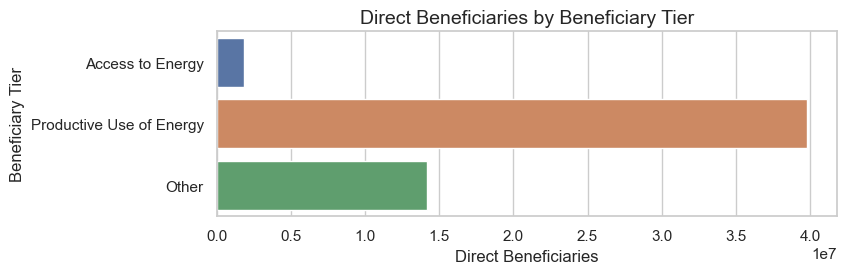

In [475]:
plotCategoryBeneficiaries("Beneficiary Tier","Direct Beneficiaries","Total")

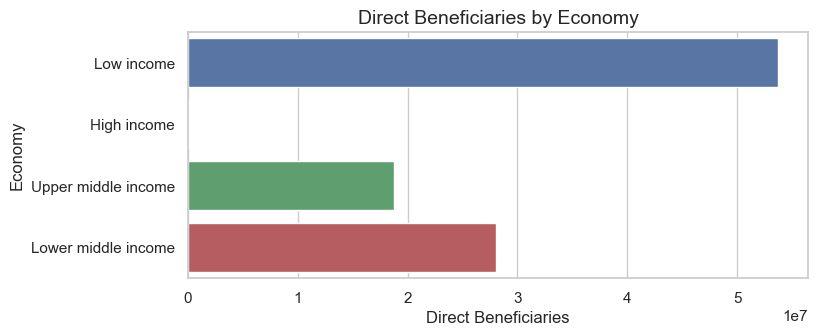

In [476]:
plotCategoryBeneficiaries("Economy","Direct Beneficiaries","Total")

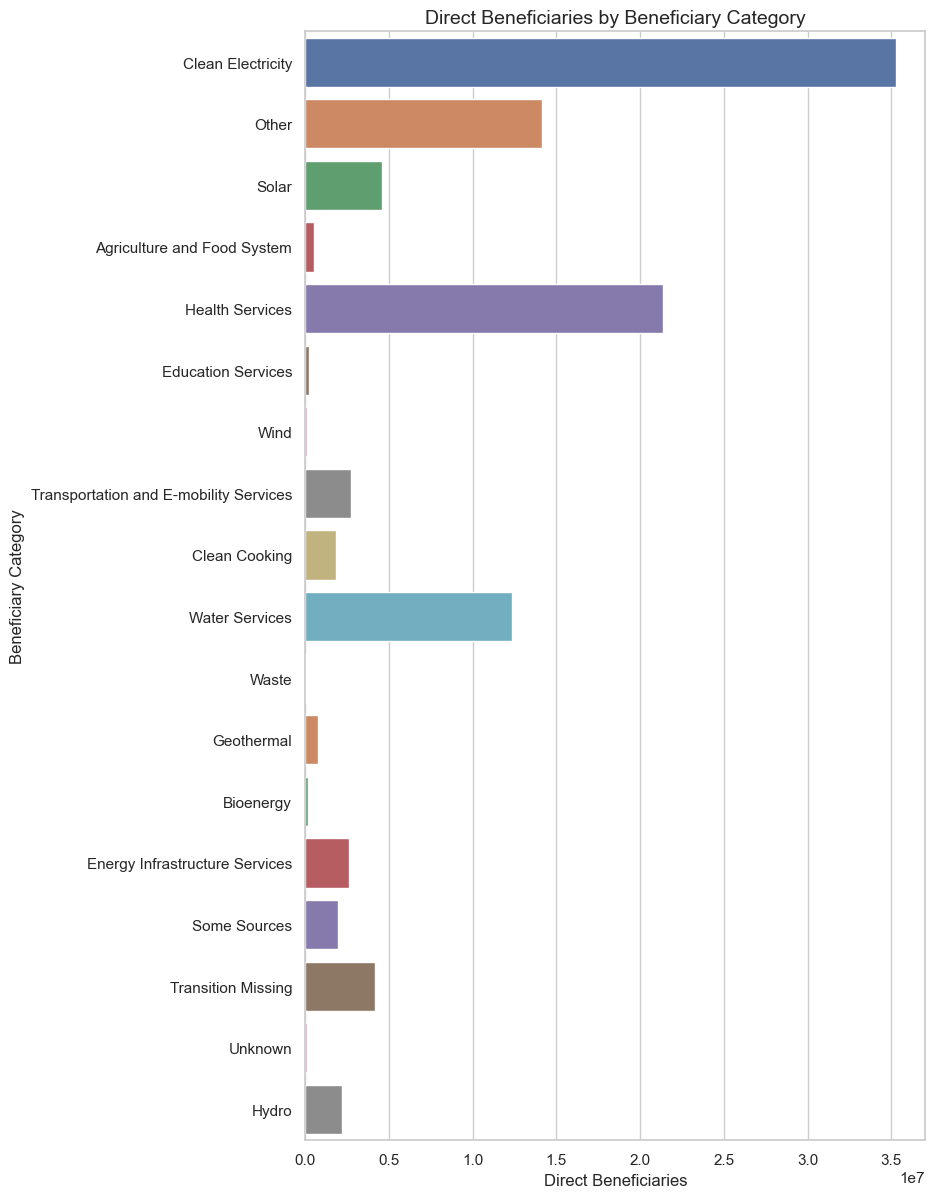

In [477]:
plotCategoryBeneficiaries("Beneficiary Category","Direct Beneficiaries","Total")

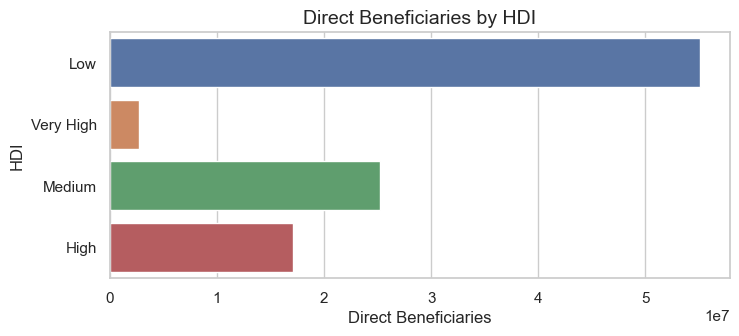

In [478]:
plotCategoryBeneficiaries("HDI","Direct Beneficiaries","Total")

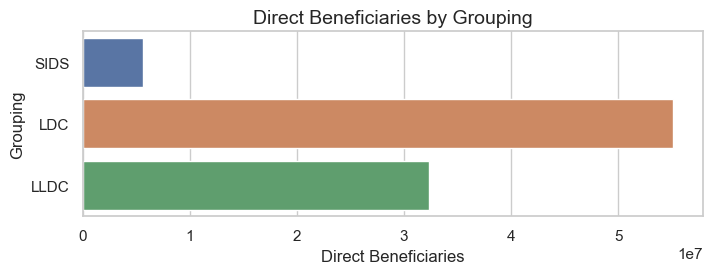

In [479]:
plotCategoryBeneficiaries("Grouping","Direct Beneficiaries","Total")

In [480]:
#df=df[df["Category"].isin(["Electricity Access","Energy (MW added)"])]

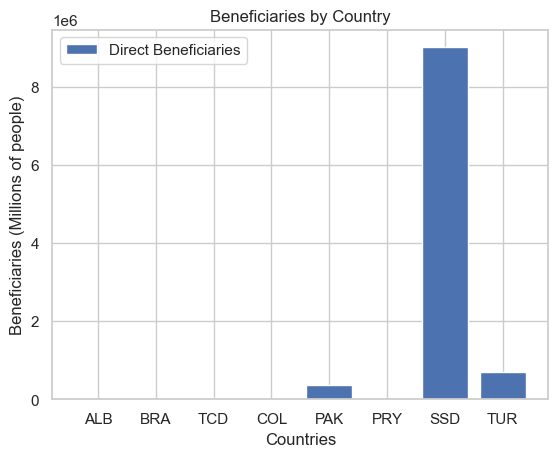

In [481]:
def plotCountryBeneficiaries():
    # Extract data from DataFrame
    
    
    df=updatedCountryMeta[updatedCountryMeta['Country Code'].isin(["BRA", "SSD", "COL", "PAK", "TUR", "TCD", "PRY", "ALB"])]
    
    #df=updatedCountryMeta.nlargest(10, 'Direct Beneficiaries')
       
    x = df['Country Code']
    y1 = df['Direct Beneficiaries']
    #y2 = df['Indirect Beneficiaries']

    # Create the stacked bar chart
    plt.bar(x, y1, label='Direct Beneficiaries')
    #plt.bar(x, y2, bottom=y1, label='Indirect Beneficiaries')

    # Add labels and title
    plt.xlabel('Countries')
    plt.ylabel('Beneficiaries (Millions of people)')
    plt.title("Beneficiaries by Country")
    plt.legend()

    # Display the chart
    plt.show()

plotCountryBeneficiaries()

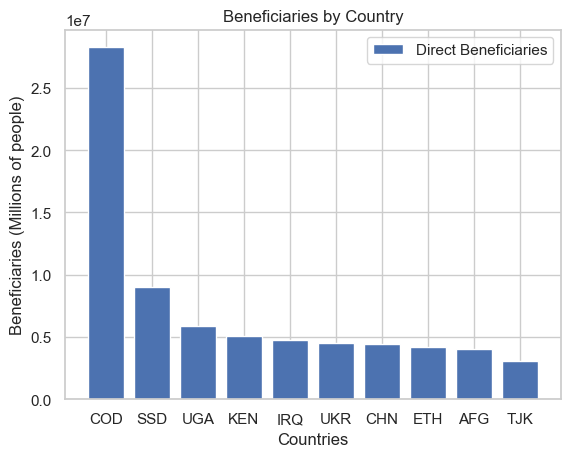

In [482]:
def plotCountryBeneficiaries():
    # Extract data from DataFrame
    
    
    
    df=updatedCountryMeta.nlargest(10, 'Direct Beneficiaries')
       
    x = df['Country Code']
    y1 = df['Direct Beneficiaries']
    #y2 = df['Indirect Beneficiaries']

    # Create the stacked bar chart
    plt.bar(x, y1, label='Direct Beneficiaries')
    #plt.bar(x, y2, bottom=y1, label='Indirect Beneficiaries')

    # Add labels and title
    plt.xlabel('Countries')
    plt.ylabel('Beneficiaries (Millions of people)')
    plt.title("Beneficiaries by Country")
    plt.legend()

    # Display the chart
    plt.show()

plotCountryBeneficiaries()

<h4> Donor analysis </h4>

In [483]:

# calculate donors stats (donors, beneficiaries)
# matplotlib


In [484]:
# projectDonors={}

# for project in projectDf["Project ID"]:
#     donorList=[]
#     for donor in projectDf["Donors"].split(",")
#         donor=donor.replace("'", "").replace("[", "").replace("]", "")

#         split=donor.split("$")
#         if len(split)>1:
#             if testNumeric(split[0]):
#                 val=split[0]
#                 donor=split[1]
#             else if testNumeric(split[1]):
#                 val=split[1]
#                 donor=split[0]
#             else:
#                 donor=split
#         donorList.append(donor)
#     projectDonors[project]=

<h3> run each output through chatgpt to generate description </h3>

In [485]:


system_prompt="You are a consultant studying outputs from UNDP energy-related projects. Generate a short description (<50 words) on the following output based on the information provided. Don't included all the project info, just the specific details of that output. Don't use the name of the country in the result (AKA don't write 'in Colombia'). Start the sentence with the action verb, as in 'Provide access to 500 million' or 'Create 1000 jobs', so don't include at the start 'This project aims to'."

# OpenAI API configuration
load_dotenv()
openai.api_type = "azure"
openai.api_key = os.getenv("api_key_azure")
openai.api_base = os.getenv("AZURE_OPENAI_ENDPOINT")
openai.api_version = os.getenv("api_version")
openai_deployment = "sdgi-gpt-35-turbo-16k"

def get_output_description(output_info):
    prompt = f"{system_prompt}\n{output_info}"
   
    response = openai.chat.completions.create(
                    model=openai_deployment,
                    temperature=0,
                    messages=[
                        {"role": "user", "content": prompt},
                    ]
                )
    output_description = response.choices[0].message.content
    return output_description

test_info='{"indicator":"number of beneficiaries","technology":"solar","target":"10000","country":"colombia"}'

get_output_description(test_info)



'Provide solar energy access to 10,000 beneficiaries.'

In [486]:

def string_to_short_sha256_hash(input_string, num_bytes=4):
    # Compute SHA-256 hash
    hash_obj = hashlib.sha256(input_string.encode())
    # Truncate to the desired number of bytes
    return str(int.from_bytes(hash_obj.digest()[:num_bytes], 'big'))

# Example usage
input_string = "Your 400 character string goes herharacter string goes herharacter string goes herharacter string goes herharacter string goes herharacter string goes herharacter string goes herharacter string goes herharacter string goes here..."
hash_value = string_to_short_sha256_hash(input_string)
print(hash_value)

3845348438


In [487]:
outputDescriptionFile="../02_Output/02_Outputs/outputDescriptions.json"
with open(outputDescriptionFile, 'r') as file:
    outputDescriptions = json.load(file)


for index, row in outputDfComplete.iterrows():
    if index<100000:
        row_hash=string_to_short_sha256_hash(' '.join(str(value) for value in row))
        print(row_hash)
        if row_hash not in outputDescriptions:
            row_dict=row.to_dict()
            row_dict["Project Description"]=projectDf[projectDf["Project ID"]==row["Project ID"]].iloc[0]["description"]
            description=get_output_description(row_dict)
            print(description)
            outputDescriptions[row_hash]=description
            outputDfComplete.loc[index, 'Description'] = description
        else:
            outputDfComplete.loc[index, 'Description'] = outputDescriptions[row_hash]
            print(index,"already complete.")
    
print(outputDescriptions)

with open(outputDescriptionFile, 'w') as file:
    json.dump(outputDescriptions, file) 
    


1530325150
0 already complete.
2422036585
1 already complete.
2083254562
2 already complete.
3336442533
3 already complete.
1336033213
4 already complete.
484673288
5 already complete.
4221506688
6 already complete.
3171955107
7 already complete.
903740503
8 already complete.
2541336239
9 already complete.
2598909302
10 already complete.
1041809678
11 already complete.
2802981088
12 already complete.
1133879038
13 already complete.
2614219158
14 already complete.
2624595964
15 already complete.
2579623788
16 already complete.
4178705309
17 already complete.
1401672261
18 already complete.
3208647293
19 already complete.
3052632561
20 already complete.
3561808266
21 already complete.
3976686352
22 already complete.
2003319754
23 already complete.
3742742020
24 already complete.
3640597439
25 already complete.
1257350527
26 already complete.
2188774773
27 already complete.
2157099686
28 already complete.
3505372114
29 already complete.
3287930452
30 already complete.
1904966422
31 alread

<h4> Export xlsx with each df as a separate sheet </h4>

In [488]:
###Export full xlsx with all dfs as tabs
# Create ExcelWriter object
writer = pd.ExcelWriter('../02_Output/00_Final Results/Moonshot Tracker Results - Auto.xlsx', engine='xlsxwriter')

# Write DataFrames to separate sheets
summaryDf.to_excel(writer, sheet_name='Summary', index=False)
outputDfComplete.to_excel(writer, sheet_name='Outputs', index=False)
projectDf.to_excel(writer, sheet_name='Projects', index=False)
updatedCountryMeta.to_excel(writer, sheet_name='Countries', index=False)
#donorDf.to_excel(writer, sheet_name='Donors', index=False)

# Save the Excel file
writer.save()

In [489]:
valuesDict={"Education Services":"Education","Agriculture and Food System":"Agriculture","Water Services":"Water","Infrastructure Services":"Infrastructure","Health Services":"Health","Transportation and E-mobility Services":"Transport"}



<h3> convert results to json format for dashboard </h3>

In [490]:
projectsJson=[]
projectDf=projectDf.fillna(np.nan).replace([np.nan], [None])
outputDfComplete=outputDfComplete.fillna(np.nan).replace([np.nan], [None])
outputDfComplete.dropna(subset=["Beneficiary Category"], inplace=True)


for index,projectRow in projectDf.iterrows():
    
    newProject={}
    newProject["id"]=str(projectRow["Project ID"]).replace(".0","")
    newProject["title"]=projectRow["Project Title"]
    linkResult=urlparse(projectRow["Link"])

    if all([linkResult.scheme, linkResult.netloc]):
        newProject["link"]=projectRow["Link"]
    else:
        newProject["link"]=None

    newProject["budget"]=projectRow["Budget"]
    newProject["countryCode"]=projectRow["Country Code"]
    newProject["countryName"]=projectRow["Country"]
    
    if projectRow["GHG Emissions Reduction"]>0:
        newProject["ghgEmissions"]= projectRow["GHG Emissions Reduction"]
    else:
        newProject["ghgEmissions"]=None
    newProject["verticalFunded"]=(projectRow["VF or Non-VF"]=="VF")
    newProject["description"]=str(projectRow["description"])
    if len(newProject["description"])<10:
        newProject["description"]="add project description"
    newProject["genderMarker"]=projectRow["Gender Marker"]
    try:
        newProject["donors"]=projectRow["Donors"].replace("[","").replace("]","").replace("'","").strip().split(",")
    except:
        newProject["donors"]=None

    if "GEN" not in newProject["genderMarker"]:
        newProject["genderMarker"]=None
    
    outputDfProject=outputDfComplete[outputDfComplete["Project ID"]==projectRow["Project ID"]]
    outputRow=outputDfProject.iloc[0]
    
    newProject["region"]=outputRow["Region"]
    try:
        newProject["thematics"]=outputRow["Tag"].split(",") 
    except:
        newProject["thematics"]=[]
    newProject["flagship"]=outputRow["Flagship"]
    newProject["hdiTier"]=outputRow["HDI"]    
    newProject["incomeGroup"]=outputRow["Economy"]
    newProject["specialGroupings"]=[outputRow[col] for col in ['SIDS', 'LLDC', 'LDC'] if not pd.isna(outputRow[col])]
 
    outputsJson=[]

    for index, outputRow in outputDfProject.iterrows():
        
        newOutput={}
        newOutput["outputCategory"]=outputRow["Output Category"]
        
        if outputRow["Beneficiary Category"] in valuesDict:
            newOutput["beneficiaryCategory"]=valuesDict[outputRow["Beneficiary Category"]]
        else:
            newOutput["beneficiaryCategory"]=outputRow["Beneficiary Category"]
        if outputRow["Beneficiary Category Pre"]=="Energy (MW added)":
            newOutput["mwAdded"]=outputRow["Target"]
        else:
            newOutput["mwAdded"]=0
         
        if outputRow["Beneficiary Category"]=="Efficiency":
            newOutput["energySaved"]=outputRow["Target"]
        else:
            newOutput["energySaved"]=0
            
        if outputRow["Beneficiary Category"]=="Policy or Regulatory Framework":
            newOutput["policies"]=1
        else:
            newOutput["policies"]=0
            
        if outputRow["Beneficiary Category"]=="Finance":
            newOutput["finance"]=0
        else:
            newOutput["finance"]=0        

        newOutput["directBeneficiaries"]=outputRow["Direct Beneficiaries"]
        newOutput["percentFemale"]=outputRow["Gender (% female)"]
#         if newOutput["percentFemale"]==False:
#             newOutput["percentFemale"]=None
        if type(newOutput["percentFemale"])==str:
            if "%" in newOutput["percentFemale"]:
                try:
                    newOutput["percentFemale"]=float(newOutput["percentFemale"].replace('%', 'e-2'))
                except:
                    newOutput["percentFemale"]=None
        try:
            if (newOutput["percentFemale"])<1:
                newOutput["percentFemale"]=newOutput["percentFemale"]*100
        except:
            newOutput["percentFemale"]=None
        newOutput["description"]=outputRow["Description"]
        
        ## confirm numeric values are numeric
        
        for key in ["energySaved","mwAdded","directBeneficiaries","percentFemale"]:
            if not isinstance(newOutput[key], (int, float, complex)) and newOutput[key]!=None:
                print(newOutput[key])
                newOutput[key]=None
                print(projectRow["Country"],newProject["id"],key,"nonnumeric")

        newOutput["id"]= (newProject["countryCode"]+"-"+newProject["id"] +"-"+ newOutput["beneficiaryCategory"] + "-"+str(len(outputsJson))).replace(" ","") 

        outputsJson.append(newOutput)
        
    newProject["outputs"]=outputsJson

    projectsJson.append(newProject)

print(projectsJson)
with open('../02_Output/06_Dashboard/moonshotData.json', 'w') as jsonfile:
    json.dump(projectsJson, jsonfile)

nan
Zambia 6613 mwAdded nonnumeric
0.15
Zambia missing-ZMB-2 mwAdded nonnumeric
2.025
Malawi 126170 mwAdded nonnumeric
1.8
South Africa 5256 mwAdded nonnumeric
0.01
Jamaica 6403 mwAdded nonnumeric
0.3
Yemen 135714 mwAdded nonnumeric
0.2
Yemen 135714 mwAdded nonnumeric

0.481
Yemen 137393 mwAdded nonnumeric
0.375
Iran 63735 mwAdded nonnumeric
1.5
Iran 63735 mwAdded nonnumeric
0.449
Comoros 6469 mwAdded nonnumeric
10.0
Comoros 5484 mwAdded nonnumeric
1.1
Suriname 122455 mwAdded nonnumeric
3.0
Botswana 5299 mwAdded nonnumeric
0.624
Ethiopia 127444 mwAdded nonnumeric
1.0
Papua New Guinea 100396 mwAdded nonnumeric
32439.375
Madagascar UNDP-MDG-00129975
UNDP-MDG-00129976 energySaved nonnumeric
0.059
Lesotho missing-LSO-1 mwAdded nonnumeric
0.358
Zimbabwe 132179 mwAdded nonnumeric
5.4
Pakistan 6542 mwAdded nonnumeric
0.56
Albania 142609 mwAdded nonnumeric
0.2
South Sudan 00080877, 00097821, 00080982, 00109097 mwAdded nonnumeric
0.0137
Dem. Rep. of the Congo 127148 mwAdded nonnumeric
0.216
Gui